In [1]:
# Author: Timur Abdualimov, SOVIET team
# Competition: Recommended system, SkillFctory
# First date code: 17.05.2020
# Used: Kaggle notebook, GPU!


import numpy as np
import pandas as pd 
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow_hub as hub

import sys
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
    
RANDOM_SEED = 13

print('Python       :', sys.version.split('\n')[0])
print('Pandas       :', pd.__version__)
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

/kaggle/input/recommendations/train.csv
/kaggle/input/recommendations/test.csv
/kaggle/input/recommendations/sample_submission.csv
Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Pandas       : 1.0.3
Numpy        : 1.18.1
Tensorflow   : 2.1.0


In [2]:
def open_data():
    """ open datasets"""
    global train, test, sample_submission # объявляем переменные глобальными
    train = pd.read_csv('/kaggle/input/recommendations/train.csv', low_memory = False)
    train = train.drop_duplicates().reset_index(drop = True) # удалим дубликаты, если есть
    test = pd.read_csv('/kaggle/input/recommendations/test.csv', low_memory = False)
    sample_submission = pd.read_csv('/kaggle/input/recommendations/sample_submission.csv')
    
open_data() # открываем все и записываем датасет в переменные

def param_data(data): # посмотрим на данные
    """dataset required parameters """
    param = pd.DataFrame({
              'dtypes': data.dtypes.values,
              'nunique': data.nunique().values,
              'isna': data.isna().sum().values,
              'loc[0]': data.loc[0].values,
              }, 
             index = data.loc[0].index)
    return param

pd.concat([param_data(train), param_data(test)], 
          axis=1, 
          keys = [f'↓ ОБУЧАЮЩАЯ ВЫБОРКА ↓ {train.shape}', f'↓ ТЕСТОВАЯ ВЫБОРКА ↓ {test.shape}'],  
          sort=False)

↓ ОБУЧАЮЩАЯ ВЫБОРКА ↓ (826895, 12)                      \
                                           dtypes   nunique      isna   
verified                                     bool       2.0       0.0   
reviewTime                                 object    4580.0       0.0   
reviewerName                               object  101207.0     164.0   
reviewText                                 object  686739.0     274.0   
summary                                    object  411451.0     166.0   
unixReviewTime                              int64    4580.0       0.0   
vote                                       object     311.0  712944.0   
style                                      object   25892.0  398698.0   
image                                      object    6636.0  819916.0   
userid                                      int64  127448.0       0.0   
itemid                                      int64   41302.0       0.0   
rating                                    float64       2.0       0.0   
Id                                            NaN       NaN       NaN   

                                                                   \
                                                           loc[0]   
verified                                                     True   
reviewTime                                             10 4, 2016   
reviewerName                                              Heather   
reviewText      These are my FAVORITE spices in my collection....   
summary                           Must Add to your Spice kitchen!   
unixReviewTime                                         1475539200   
vote                                                          NaN   
style                                                         NaN   
image                                                         NaN   
userid                                                     102179   
itemid                                                      37138   
rating                                                          1   
Id                                                            NaN   

               ↓ ТЕСТОВАЯ ВЫБОРКА ↓ (285965, 12)                      \
                                          dtypes   nunique      isna   
verified                                    bool       2.0       0.0   
reviewTime                                object    4349.0       0.0   
reviewerName                              object   86815.0      47.0   
reviewText                                object  247832.0     111.0   
summary                                   object  154343.0      57.0   
unixReviewTime                             int64    4349.0       0.0   
vote                                      object     198.0  246503.0   
style                                     object   18904.0  138285.0   
image                                     object    2306.0  283597.0   
userid                                     int64  109357.0       0.0   
itemid                                     int64   37876.0       0.0   
rating                                       NaN       NaN       NaN   
Id                                         int64  285965.0       0.0   

                            
                    loc[0]  
verified              True  
reviewTime      10 1, 2016  
reviewerName     Rudys Mom  
reviewText         Yum....  
summary         Five Stars  
unixReviewTime  1475280000  
vote                   NaN  
style                  NaN  
image                  NaN  
userid               68877  
itemid                7506  
rating                 NaN  
Id                       0

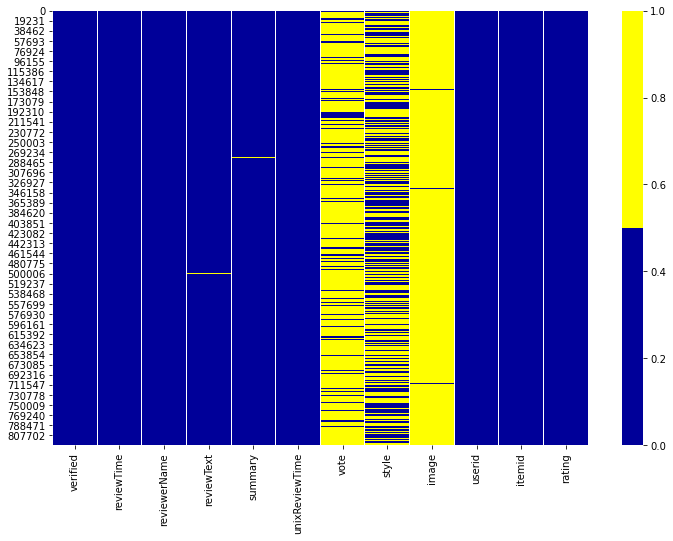

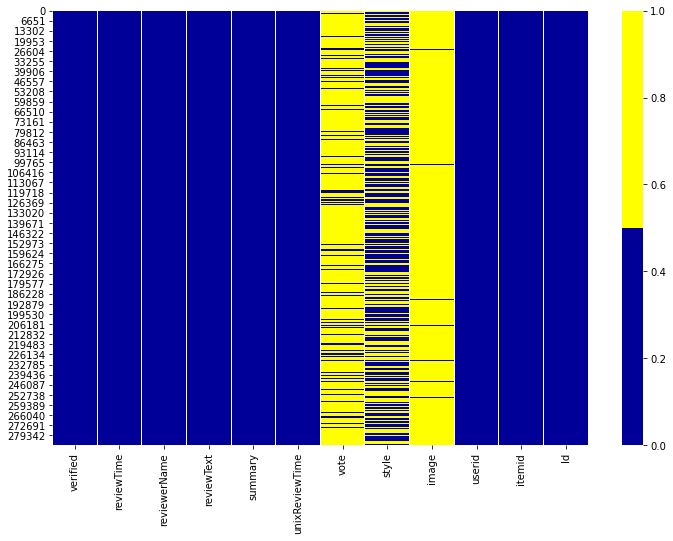

In [3]:
def viz_na(data):
    """NA visualisation"""
    global cols
    cols = data.columns # запишем названия строки сделаем переменную глобальной
    # определяем цвета 
    # желтый - пропущенные данные, синий - не пропущенные
    colours = ['#000099', '#ffff00'] 
    sns.heatmap(data[cols].isnull(), cmap=sns.color_palette(colours))
    plt.show()


viz_na(train)
viz_na(test)

In [4]:
def stat_na_per_percent(data):
    print(f'{data.shape}')
    for col in data.columns:
        pct_missing = np.mean(data[col].isnull())
        print('{} - {}%'.format(col, round(pct_missing*100)))
    print("END", end = '\n\n')
stat_na_per_percent(train)
stat_na_per_percent(test)

(826895, 12)
verified - 0.0%
reviewTime - 0.0%
reviewerName - 0.0%
reviewText - 0.0%
summary - 0.0%
unixReviewTime - 0.0%
vote - 86.0%
style - 48.0%
image - 99.0%
userid - 0.0%
itemid - 0.0%
rating - 0.0%
END

(285965, 12)
verified - 0.0%
reviewTime - 0.0%
reviewerName - 0.0%
reviewText - 0.0%
summary - 0.0%
unixReviewTime - 0.0%
vote - 86.0%
style - 48.0%
image - 99.0%
userid - 0.0%
itemid - 0.0%
Id - 0.0%
END



In [5]:
def concat_train_test(train , test):
    """
    prepare final data, concat train and test
    """
    global orta
    train['sample'] = 1 # объединяем трейн и тест для совместных правок
    test['sample'] = 0
    test['rating'] = -2
    orta = train.append(test, sort = False).reset_index(drop = True) # закончили объединение и присвоили имя основной перемнной
    orta.drop(['Id'], axis = 1, inplace = True)

concat_train_test(train, test)

In [6]:
orta.select_dtypes(include = ['float64', 'int64'])

,unixReviewTime,userid,itemid,rating,sample
0,1475539200,102179,37138,1.0,1
1,1456790400,3625,17322,1.0,1
2,1466899200,39495,5600,1.0,1
3,1378339200,72854,30249,1.0,1
4,1473811200,74859,4349,1.0,1
...,...,...,...,...,...
1112855,1452988800,294,25601,-2.0,0
1112856,1440201600,119653,18204,-2.0,0
1112857,1505952000,54673,2287,-2.0,0
1112858,1522108800,16569,9343,-2.0,0


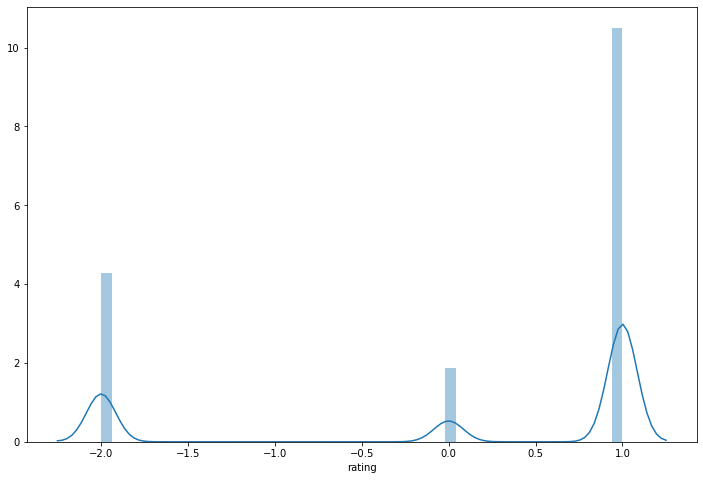

In [7]:
sns.distplot(orta['rating'], label = 'rating')
plt.show()

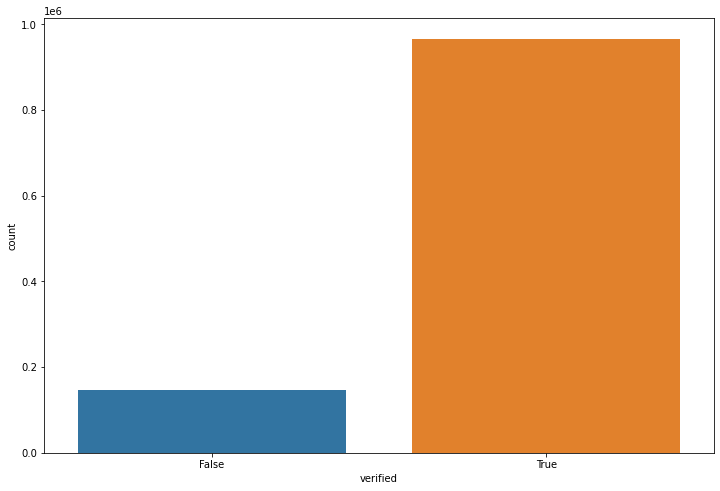

In [8]:
sns.countplot(x='verified', data=orta, label = 'verified');

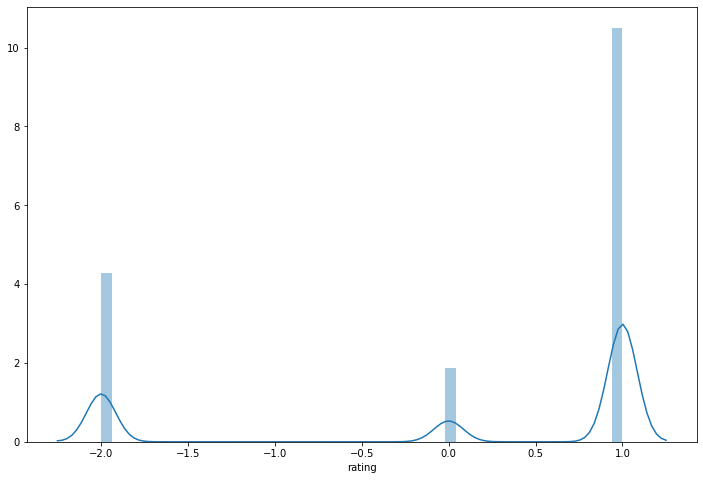

In [9]:
sns.distplot(orta['rating'], label = 'rating')
plt.show()

In [10]:
orta.isna().sum()

verified                0
reviewTime              0
reviewerName          211
reviewText            385
summary               223
unixReviewTime          0
vote               959447
style              536983
image             1103513
userid                  0
itemid                  0
rating                  0
sample                  0
dtype: int64

In [11]:
# удалим столбцы с пропусками где процент больше 80%
orta = orta.drop(['image', 'vote'], axis = 1)

In [12]:
# создадим отдельные столбцы, которые показывают были ли пропущенные значения в столбцах и заполним пропуски
for i in orta.columns:
    if orta[i].isna().sum() != 0:
        orta[str(i) + '_isNAN'] = pd.isna(orta[i]).astype('uint8')
        orta[i] = orta[i].fillna('[]')

# удалим столбцы style, reviewerName, reviewTime за ненадобностью
orta = orta.drop(['style', 'reviewerName', 'reviewTime'], axis = 1)

# перевдем столбец verified в числовой
orta['verified'] = orta['verified'].astype(int)

# создадим столбцы где указывается длина текста в столбцах reviewText, summary
text_len_col = ['reviewText', 'summary']
for i in text_len_col:
    orta[str(i) + '_len'] = orta[i].apply(lambda x: len(x))

# переведем столбец с unixtime в нормальные часики    
orta['unixReviewTime'] = pd.to_datetime(orta['unixReviewTime'], unit='s')
# сколько прошло дней
orta['DaysPassed'] = (pd.datetime.now() - orta['unixReviewTime']).dt.days
# день недели в который оставили отзыв
orta['reviewWeekday'] = orta['unixReviewTime'].dt.weekday
# удалим столбец со временем за ненадобностью
orta = orta.drop(['unixReviewTime'], axis = 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


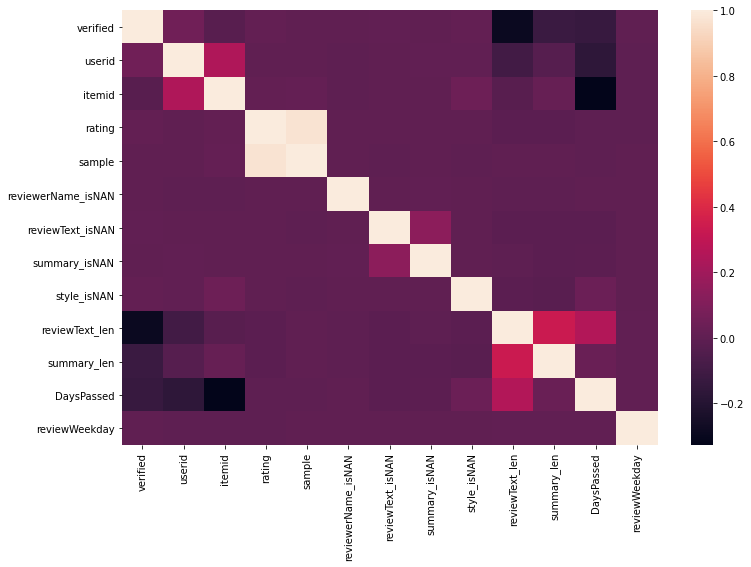

In [13]:
sns.heatmap(orta.corr())
plt.show()

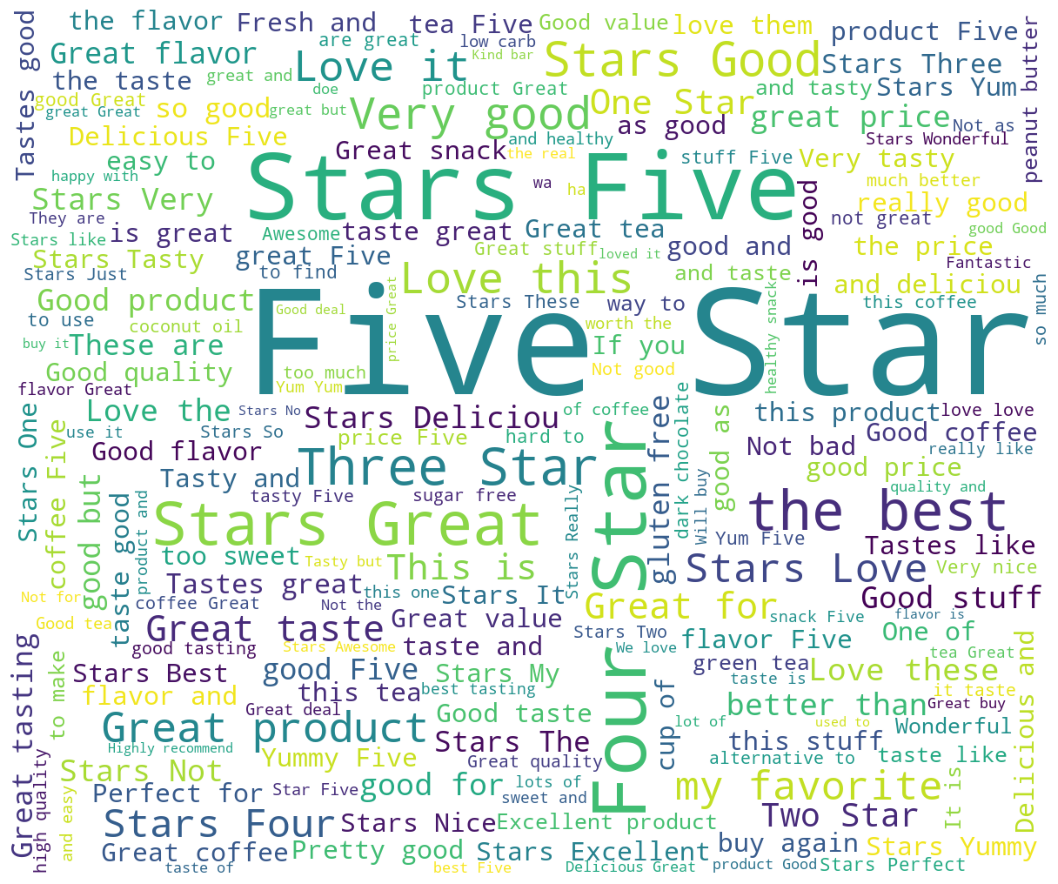

In [14]:
full_text = ' '.join([i for i in orta['summary']])

cloud = WordCloud(background_color='white', width=1200, height=1000).generate_from_text(full_text)
plt.figure(figsize=(25,16))
plt.axis('off')
plt.imshow(cloud);

In [15]:
train_data = orta.query('sample == 1').drop('sample', axis = 1)
test_data = orta.query('sample == 0').drop(['sample', 'rating'], axis = 1)

train_data = pd.get_dummies(train_data, prefix='', prefix_sep='', columns=['rating'])

In [16]:
input_1 = Input(shape=(), dtype=tf.string,  name = "Input_1")
input_2 = Input(shape=(), dtype=tf.string,  name = "Input_2")
input_3 = Input(shape=(11,), name = "Input_3")
embedding = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
hub_layer_1 = hub.KerasLayer(embedding, input_shape=[],  dtype=tf.string, trainable=True)
hub_layer_2 = hub.KerasLayer(embedding, input_shape=[],  dtype=tf.string, trainable=True)
    

x = hub_layer_1(input_1)
x = Dense(128, activation='elu')(x)
x = Model(inputs=input_1, outputs=x)


y = hub_layer_2(input_2)
y = Dense(128, activation='elu')(y)
y = Model(inputs=input_2, outputs=y)

z = Dense(128, activation="elu")(input_3)
z = Dense(128, activation="elu")(z)
z = Model(inputs=input_3, outputs=z)

u8 = concatenate([x.output, y.output, z.output])

q = Dense(128, activation='elu')(u8)
predictions = Dense(2, activation='softmax')(q)


tf.keras.backend.clear_session()
model = Model(inputs=[x.input, y.input, z.input], outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()    

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
Input_2 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
Input_3 (InputLayer)            [(None, 11)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 128)          124642688   Input_1[0][0]                    
______________________________________________________________________________________________

In [17]:
history = model.fit([train_data['reviewText'], train_data['summary'], train_data.iloc[:,[0,3,4,5,6,7,8,9,10,11,12]]],
                    train_data.iloc[:,[-2,-1]],
                    epochs=3,
                    batch_size=200,
                    )

Train on 826895 samples
Epoch 1/3
826895/826895 [==============================] - 297s 359us/sample - loss: 10.9980 - accuracy: 0.9066
Epoch 2/3
826895/826895 [==============================] - 294s 356us/sample - loss: 0.2592 - accuracy: 0.9411
Epoch 3/3
731200/826895 [=========================>....] - ETA: 33s - loss: 0.1142 - accuracy: 0.9545

In [18]:
pred = model.predict([test_data['reviewText'], test_data['summary'], test_data.iloc[:,[0,3,4,5,6,7,8,9,10,11,12]]])

In [19]:
pred = np.argmax(pred, axis=-1)
sample_submission['rating'] = pred
sample_submission.to_csv('submission_2.csv', index=False)
sample_submission.head(3)

,Id,rating
0,0,1
1,1,1
2,2,1


In [20]:
"""input_3 = Input(shape=(11,), name = "Input_3")
x = Dense(128, activation="elu")(input_3)
x = Dense(128, activation="elu")(x)
predictions = Dense(2, activation='softmax')(x)

tf.keras.backend.clear_session()
mod = Model(inputs=input_3, outputs=predictions)
mod.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

mod.summary()    
"""

'input_3 = Input(shape=(11,), name = "Input_3")\nx = Dense(128, activation="elu")(input_3)\nx = Dense(128, activation="elu")(x)\npredictions = Dense(2, activation=\'softmax\')(x)\n\ntf.keras.backend.clear_session()\nmod = Model(inputs=input_3, outputs=predictions)\nmod.compile(optimizer=\'adam\', loss=\'categorical_crossentropy\', metrics=[\'accuracy\'])\n\nmod.summary()    \n'

In [21]:
"""his = mod.fit(train_data.iloc[:,[0,3,4,5,6,7,8,9,10,11,12]],
                    train_data.iloc[:,[-2,-1]],
                    epochs=3,
                    batch_size=100,
                    )
"""

'his = mod.fit(train_data.iloc[:,[0,3,4,5,6,7,8,9,10,11,12]],\n                    train_data.iloc[:,[-2,-1]],\n                    epochs=3,\n                    batch_size=100,\n                    )\n'

In [22]:
"""
embedding = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)



x = hub_layer.output
x = Dense(128, activation='elu')(x)
x = Model(inputs=hub_layer.input, outputs=x)


y = hub_layer.output
y = Dense(128, activation='elu')(y)
y = Model(inputs=hub_layer.input, outputs=y)


u8 = concatenate([x.output, y.output])

q = Dense(128, activation='elu')(u8)
predictions = Dense(2, activation='softmax')(q)


tf.keras.backend.clear_session()
model = Model(inputs=[x.input, y.input], outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()
"""

'\nembedding = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"\nhub_layer = hub.KerasLayer(embedding, input_shape=[], \n                           dtype=tf.string, trainable=True)\n\n\n\nx = hub_layer.output\nx = Dense(128, activation=\'elu\')(x)\nx = Model(inputs=hub_layer.input, outputs=x)\n\n\ny = hub_layer.output\ny = Dense(128, activation=\'elu\')(y)\ny = Model(inputs=hub_layer.input, outputs=y)\n\n\nu8 = concatenate([x.output, y.output])\n\nq = Dense(128, activation=\'elu\')(u8)\npredictions = Dense(2, activation=\'softmax\')(q)\n\n\ntf.keras.backend.clear_session()\nmodel = Model(inputs=[x.input, y.input], outputs=predictions)\nmodel.compile(optimizer=\'adam\', loss=\'categorical_crossentropy\', metrics=[\'accuracy\'])\n\nmodel.summary()\n'